In [1]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")

from train import *
from create_graphs import *
%matplotlib inline

print ('CUDA Available:', torch.cuda.is_available())

CUDA Available: True


In [3]:
# Generate the model datasets (i.e. the dataset used to train
# the model - normal data)
args_prot1, train_prot1, val_prot1, test_prot1 = get_graph_data("DD_1", isModelDataset=True)
# Save the max_previous node to allow for model 
# compatability on future datasets
max_prev_node = args_prot1.max_prev_node

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
train_dataset = Graph_sequence_sampler_pytorch_rand(train_prot1,max_prev_node=max_prev_node,max_num_node=args_prot1.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args_prot1.num_workers)

test_dataset = Graph_sequence_sampler_pytorch_rand(test_prot1, max_prev_node=args_prot1.max_prev_node,max_num_node=args_prot1.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args_prot1.num_workers)

# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args_prot1.max_prev_node, embedding_size=args_prot1.embedding_size_rnn,
                        hidden_size=args_prot1.hidden_size_rnn, num_layers=args_prot1.num_layers, has_input=True,
                        has_output=True, output_size=args_prot1.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args_prot1.embedding_size_rnn_output,
                        hidden_size=args_prot1.hidden_size_rnn_output, num_layers=args_prot1.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)
# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
train_nlls, train_avg_nlls = calc_nll(args_prot1, train_loader, rnn, output, max_iter=10, load_epoch=2500, log=1)

train_avg_nlls_iter = np.array(train_avg_nlls)
train_avg_nlls_iter = train_avg_nlls_iter.reshape((10, len(train_loader)))
train_avg_nlls_iter = np.mean(train_avg_nlls_iter, axis=0)

# Analysis of the test data set nlls.
# We really gotta train over more data!
test_nlls, test_avg_nlls = calc_nll(args_prot1, test_loader, rnn, output, load_epoch=2500, max_iter=10, log=1)

test_avg_nlls_iter = np.array(test_avg_nlls)
test_avg_nlls_iter = test_avg_nlls_iter.reshape((10, len(test_loader)))
test_avg_nlls_iter = np.mean(test_avg_nlls_iter, axis=0)


Loading graph dataset: DD
Loaded
Average num nodes 293.2783505154639
total graph num: 582
max number node: 500
max/min number edge: 1575; 186
max previous node: 230
./model_save/GraphRNN_RNN_DD_1_4_128_lstm_2500.dat
model loaded!, epoch: 2500
Iteration: 1
Average Nll over train data: 1719.2076973863827
Iteration: 2
Average Nll over train data: 1722.475047843687
Iteration: 3
Average Nll over train data: 1716.1245942802839
Iteration: 4
Average Nll over train data: 1718.4781071488576
Iteration: 5
Average Nll over train data: 1719.559089841125
Iteration: 6
Average Nll over train data: 1720.8957141507055
Iteration: 7
Average Nll over train data: 1721.0986621487525
Iteration: 8
Average Nll over train data: 1715.9513450704594
Iteration: 9
Average Nll over train data: 1718.4292311801705
Iteration: 10
Average Nll over train data: 1716.9269877115885
./model_save/GraphRNN_RNN_DD_1_4_128_lstm_2500.dat
model loaded!, epoch: 2500
Iteration: 1
Average Nll over train data: 1717.8515171148838
Iteration

In [4]:
# Analysis of the test data set nlls.
# We really gotta train over more data!
test_nlls, test_avg_nlls = calc_nll(args_prot1, test_loader, rnn, output, load_epoch=2500, max_iter=10, log=1)

test_avg_nlls_iter = np.array(test_avg_nlls)
test_avg_nlls_iter = test_avg_nlls_iter.reshape((10, len(test_loader)))
test_avg_nlls_iter = np.mean(test_avg_nlls_iter, axis=0)

./model_save/GraphRNN_RNN_DD_1_4_128_lstm_2500.dat
model loaded!, epoch: 2500
Iteration: 1
Average Nll over train data: 1714.7201691651956


Process Process-86:
Process Process-88:
Process Process-85:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/lfs/hyperion3/0/jgs8/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/lfs/hyperion3/0/jgs8/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/lfs/hyperion3/0/jgs8/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/lfs/hyperion3/0/jgs8/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/lfs/hyperion3/0/jgs8/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/lfs/hyperion3/0/jgs8/newenv/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/lfs/hyperion3/0/jgs8/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/lfs/hyperi

In [5]:
def compare_dist(nlls, labels=['Nomarl', 'Anomalous'], title="Normal vs. Anomalous NLL Distributions"):
    fig, ax = plt.subplots()
    for i in range(len(nlls)):
        sns.distplot(nlls[i], ax=ax, kde=True, label=labels[i])
    ax.legend()
    ax.set_xlabel("Negative Log Likelihood")
    ax.set_title(title)
    return fig, ax

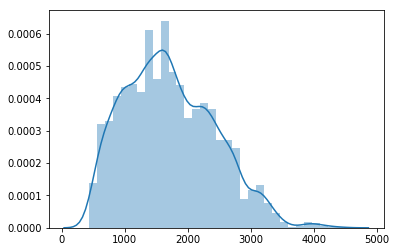

In [6]:
# Plot un averaged nlls (over the feature dimensions of the graph sequence) for the model's training dataset
plt.figure()
hist = sns.distplot(train_nlls,kde=True)

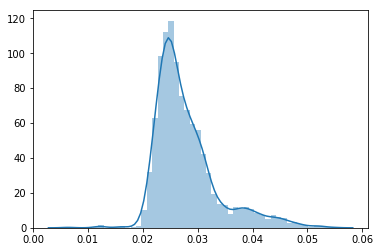

In [7]:
# Plot un averaged nlls (over the feature dimensions of the graph sequence) for the model's training dataset
plt.figure()
hist = sns.distplot(train_avg_nlls,kde=True)

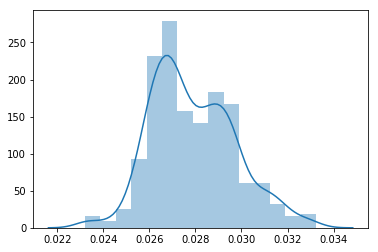

In [16]:
# Average the likelihoods across the iterations for each graph
plt.figure()
train_avg_nlls_iter = np.array(train_avg_nlls)
train_avg_nlls_iter = train_avg_nlls_iter.reshape((len(train_loader), 10))
train_avg_nlls_iter = np.mean(train_avg_nlls_iter, axis=1)
sns.distplot(train_avg_nlls_iter,kde=True)

Text(0.5,1,'NLL summed across features')

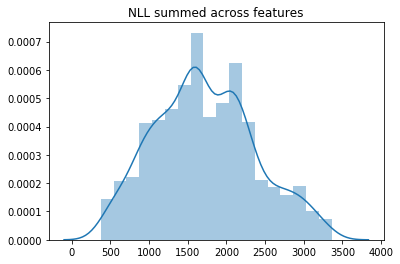

In [9]:
# Un-averaged nlls over the test normal distribution
plt.figure()
sns.distplot(test_nlls, kde=True)
plt.title('NLL summed across features')

(117,)


Text(0.5,1,'NLL averaged over Features and Iterations ')

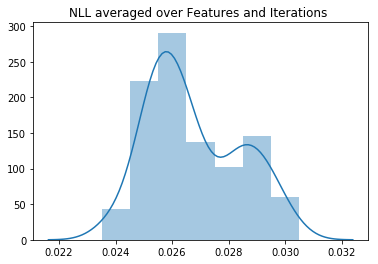

In [23]:
# Average the likelihoods across the iterations for each graph
plt.figure()
test_avg_nlls_iter = np.array(test_avg_nlls)
test_avg_nlls_iter = test_avg_nlls_iter.reshape((len(test_loader), 10))
test_avg_nlls_iter = np.mean(test_avg_nlls_iter, axis=1)
sns.distplot(test_avg_nlls_iter,kde=True)
plt.title("NLL averaged over Features and Iterations ")

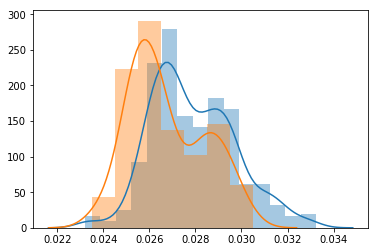

In [18]:
fig, ax = plt.subplots()
for a in [train_avg_nlls_iter, test_avg_nlls_iter]:
    sns.distplot(a, ax=ax, kde=True)

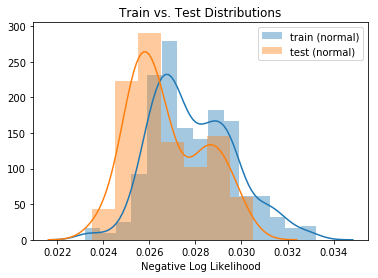

In [19]:
fig, ax_compare = compare_dist([train_avg_nlls_iter, test_avg_nlls_iter], 
                               ['train (normal)', 'test (normal)'], 
                              'Train vs. Test Distributions')
fig.savefig("NLL_Figures/Train_Test_Protein1")

# Now we will test the proteins that are not enzymes


In [13]:
# Starting with enzyme with label 2
args_prot2, graphs_prot2 = get_graph_data("DD_2", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
prot2_dataset = Graph_sequence_sampler_pytorch_rand(graphs_prot2,max_prev_node=max_prev_node,max_num_node=args_prot2.max_num_node)
prot2_loader = torch.utils.data.DataLoader(prot2_dataset, batch_size=1, num_workers=args_prot2.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
prot2_nlls, prot2_avg_nlls = calc_nll(args_prot1, prot2_loader, rnn, output, max_iter=10, load_epoch=1800, train_dataset="DD_1", log=1)

prot2_avg_nlls_iter = np.array(prot2_avg_nlls)
prot2_avg_nlls_iter = prot2_avg_nlls_iter.reshape((10, len(prot2_loader)))
prot2_avg_nlls_iter = np.mean(prot2_avg_nlls_iter, axis=0)


Loading graph dataset: DD
Loaded
Average num nodes 196.5297619047619
total graph num: 336
max number node: 456
max/min number edge: 1211; 198
max previous node: 230
./model_save/GraphRNN_RNN_DD_1_4_128_lstm_1800.dat
model loaded!, epoch: 1800
Iteration: 1
Average Nll over train data: 1080.7556240445092
Iteration: 2
Average Nll over train data: 1082.326563199361
Iteration: 3
Average Nll over train data: 1084.6219880694434
Iteration: 4
Average Nll over train data: 1086.7313208807082
Iteration: 5
Average Nll over train data: 1084.7247225443523
Iteration: 6
Average Nll over train data: 1086.119742575146
Iteration: 7
Average Nll over train data: 1085.9385340100243
Iteration: 8
Average Nll over train data: 1078.5915110451836
Iteration: 9
Average Nll over train data: 1082.7074316569738
Iteration: 10
Average Nll over train data: 1077.9375379653204


Text(0.5,1,'Comparison of Prot1 and Prot2 (avg nll over iteration)')

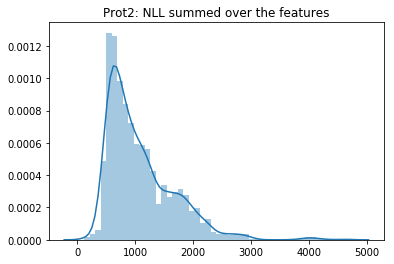

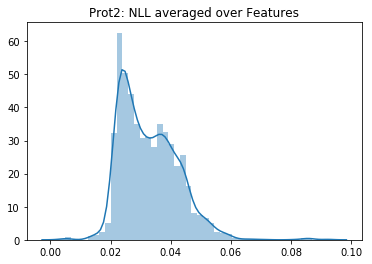

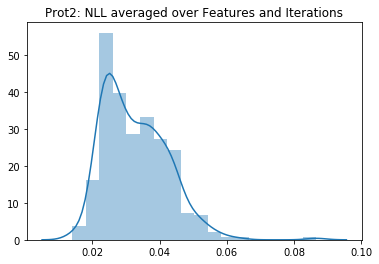

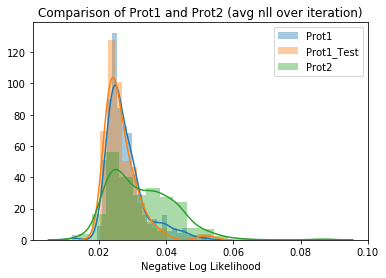

In [14]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(prot2_nlls, kde=True)
plt.title("Prot2: NLL summed over the features")


# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(prot2_avg_nlls,kde=True)
plt.title("Prot2: NLL averaged over Features")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(prot2_avg_nlls_iter,kde=True)
plt.title("Prot2: NLL averaged over Features and Iterations")

fig, ax = plt.subplots()
labels = ["Prot1", "Prot1_Test", "Prot2"]
likelihoods = [train_avg_nlls_iter, test_avg_nlls_iter, prot2_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Comparison of Prot1 and Prot2 (avg nll over iteration)')

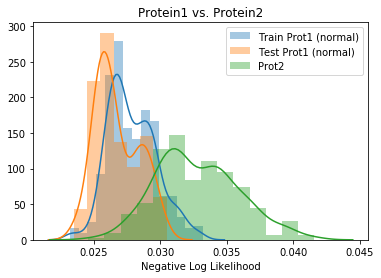

In [21]:
prot2_avg_nlls_iter = np.array(prot2_avg_nlls)
prot2_avg_nlls_iter = prot2_avg_nlls_iter.reshape((len(prot2_loader), 10))
prot2_avg_nlls_iter = np.mean(prot2_avg_nlls_iter, axis=1)
fig, ax_compare = compare_dist([train_avg_nlls_iter, test_avg_nlls_iter, prot2_avg_nlls_iter],
                               ['Train Prot1 (normal)', 'Test Prot1 (normal)', 'Prot2'],
                              "Protein1 vs. Protein2")
fig.savefig("NLL_Figures/Protein1-Vs-Prot2")